In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import numpy as np
import os
from os.path import join
from PIL import Image

In [2]:
# Sort train_small data into subfolders according to class
data_dir = r"C:\Users\jjuus\OneDrive - purdue.edu\ECE 50024\Kaggle"

# Get ending picture directories
# jtc_data_dir = join(data_dir, r"train_small_jtc")
jtc_data_dir = join(data_dir, r"train_jtc_cropped3")

data_dir = jtc_data_dir

# batch_size = 32
# epochs = 8
batch_size = 128
epochs = 50
workers = 0 if os.name == 'nt' else 8

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])
dataset = datasets.ImageFolder(data_dir, transform=trans)

resnet = InceptionResnetV1(
    classify=True,
    pretrained='casia-webface',
    num_classes=len(dataset.class_to_idx)
).to(device)

# optimizer = optim.Adam(resnet.parameters(), lr=0.001)
# scheduler = MultiStepLR(optimizer, [5, 10])
optimizer = optim.Adam(resnet.parameters(), lr=0.00001)
scheduler = MultiStepLR(optimizer, [20, 40])
img_inds = np.arange(len(dataset))
np.random.shuffle(img_inds)
train_inds = img_inds[:int(0.99 * len(img_inds))]
val_inds = img_inds[int(0.99 * len(img_inds)):]

train_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(train_inds)
)
val_loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(val_inds)
)

loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

Running on device: cuda:0


In [3]:
dataset.class_to_idx

{'aaron_judge': 0,
 'aaron_paul': 1,
 'aaron_taylor-johnson': 2,
 'abigail_breslin': 3,
 'adam_sandler': 4,
 'adele': 5,
 'adriana_barraza': 6,
 'adriana_lima': 7,
 'adrianne_palicki': 8,
 'adrien_brody': 9,
 'akemi_darenogare': 10,
 'al_pacino': 11,
 'al_roker': 12,
 'alan_alda': 13,
 'alan_arkin': 14,
 'alan_rickman': 15,
 'albert_brooks': 16,
 'albert_finney': 17,
 'alec_baldwin': 18,
 'alessandra_ambrosio': 19,
 'alex_pettyfer': 20,
 'alexander_skarsgard': 21,
 'alexandra_daddario': 22,
 'alexis_thorpe': 23,
 'ali_larter': 24,
 'alice_eve': 25,
 'alicia_vikander': 26,
 'alx_james': 27,
 'amanda_bynes': 28,
 'amanda_crew': 29,
 'amanda_peet': 30,
 'amanda_seyfried': 31,
 'amber_heard': 32,
 'amy_adams': 33,
 'amy_ryan': 34,
 'amy_schumer': 35,
 'analeigh_tipton': 36,
 'anderson_cooper': 37,
 'andie_macdowell': 38,
 'andreea_diaconu': 39,
 'andrew_garfield': 40,
 'andrew_lincoln': 41,
 'andrew_luck': 42,
 'andy_garcia': 43,
 'andy_murray': 44,
 'andy_samberg': 45,
 'andy_serkis': 46,

#### Train Model

In [4]:
# Takes about 1 min per 1000 training images (8 epochs)
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
resnet.eval()
training.pass_epoch(
    resnet, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet.train()
    training.pass_epoch(
        resnet, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    resnet.eval()
    training.pass_epoch(
        resnet, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    if (epoch+1) % 2 == 0:
        # Save model to file
        dst = r"./all_model_v12/model_v12_epoch" + str(epoch+1) + r".pt"
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        torch.save(resnet, dst)

writer.close()



Initial
----------
Valid |     6/6    | loss:    4.7300 | fps:  268.4933 | acc:    0.0078   

Epoch 1/50
----------
Train |   531/531  | loss:    3.4501 | fps:  154.5970 | acc:    0.3847   
Valid |     6/6    | loss:    2.4030 | fps:  310.7832 | acc:    0.6741   

Epoch 2/50
----------
Train |   531/531  | loss:    2.0357 | fps:  158.2896 | acc:    0.7109   
Valid |     6/6    | loss:    1.5594 | fps:  293.4863 | acc:    0.7815   

Epoch 3/50
----------
Train |   531/531  | loss:    1.4350 | fps:  153.7389 | acc:    0.7711   
Valid |     6/6    | loss:    1.2583 | fps:  315.0201 | acc:    0.7992   

Epoch 4/50
----------
Train |   531/531  | loss:    1.1222 | fps:  157.6863 | acc:    0.8055   
Valid |     6/6    | loss:    1.0741 | fps:  313.1299 | acc:    0.8157   

Epoch 5/50
----------
Train |   531/531  | loss:    0.9116 | fps:  158.7972 | acc:    0.8336   
Valid |     6/6    | loss:    0.9345 | fps:  311.8604 | acc:    0.8312   

Epoch 6/50
----------
Train |   531/531  | loss: 

In [5]:
# Save model to file
dst = r"./model_v8.pt"
torch.save(resnet, dst)

In [5]:
# Load model from file
src = r"./all_model_v12/model_v12_epoch26.pt"
resnet = torch.load(src)

In [6]:
# Validation passthrough
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
resnet.eval()
training.pass_epoch(
    resnet, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)



Initial
----------
Valid |    54/54   | loss:    1.3150 | fps:  324.3429 | acc:    0.8345   


(tensor(1.3150), {'fps': tensor(324.3429), 'acc': tensor(0.8345)})

In [5]:
class_names = list(dataset.class_to_idx.keys())
class_names[15]

'alan_rickman'

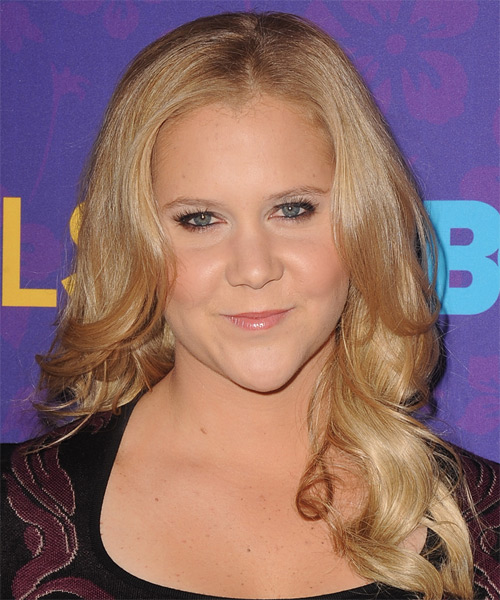

tensor([[[ 0.2305,  0.2305,  0.2070,  ...,  0.3320,  0.3008,  0.2070],
         [ 0.2148,  0.2070,  0.2461,  ...,  0.4492,  0.3711,  0.2461],
         [ 0.1758,  0.2227,  0.2305,  ...,  0.4023,  0.4023,  0.3477],
         ...,
         [-0.0820, -0.1445, -0.1445,  ...,  0.1758,  0.1289,  0.1445],
         [-0.0664, -0.1680, -0.1523,  ...,  0.0352,  0.1289,  0.1523],
         [ 0.0352, -0.1602, -0.1367,  ..., -0.0195,  0.0742,  0.0977]],

        [[-0.0508, -0.0430, -0.0664,  ...,  0.0820,  0.0586, -0.0273],
         [-0.0898, -0.0898, -0.0430,  ...,  0.1836,  0.1211,  0.0117],
         [-0.1211, -0.0742, -0.0586,  ...,  0.1445,  0.1602,  0.1133],
         ...,
         [-0.4727, -0.5352, -0.5352,  ..., -0.2617, -0.3164, -0.2773],
         [-0.4492, -0.5352, -0.5352,  ..., -0.3867, -0.2930, -0.2773],
         [-0.3320, -0.5352, -0.5117,  ..., -0.4102, -0.3555, -0.3477]],

        [[-0.3398, -0.3320, -0.3711,  ..., -0.1289, -0.1523, -0.2305],
         [-0.3477, -0.3711, -0.3398,  ..., -0

In [94]:
# Load test image
test_img_path = r"C:\Users\jjuus\OneDrive - purdue.edu\ECE 50024\Kaggle\test\test"
test_img = Image.open(join(test_img_path, '3415.jpg'))
display(test_img)

# Get cropped and prewhitened image tensor
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)
test_img_cropped = mtcnn(test_img, save_path="./test.jpg").to(device)

print(test_img_cropped)

# Or, if using for VGGFace2 classification
resnet.eval()
img_probs = resnet(test_img_cropped.unsqueeze(0))
class_idx = torch.argmax(img_probs).item()
print(class_idx)
print("Prediction: ", class_names[class_idx])
print("img_probs: ", img_probs)
print("img_probs.shape: ", img_probs.shape)

#### Run through test data


In [8]:
# Takes approximately 5 min to run through all test data
# Accuracy is about 0.04 (4%) less than the final validation accuracy from training
# Now accuracy is about 0.017 (1.7%) less than final validation accuracy from training with test_jtc_cropped2

import pandas as pd
from tqdm import tqdm
import os.path
import csv

# Get lookup class csv
data_dir = r"C:\Users\jjuus\OneDrive - purdue.edu\ECE 50024\Kaggle"
my_classes_mat = pd.read_csv(join(data_dir, "category_lookup.csv"))
my_classes_mat
their_name_vec = my_classes_mat['their_name']


test_img_path = r"C:\Users\jjuus\OneDrive - purdue.edu\ECE 50024\Kaggle\test_jtc_cropped3"
# test_dataset = datasets.ImageFolder(test_img_path, transform=trans)
# test_loader = DataLoader(
#     test_dataset,
#     num_workers=workers,
#     batch_size=1,
#     sampler=SubsetRandomSampler(val_inds)
# )

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])

test_names = []
resnet.eval()
# Loop through all test images
# Actual number of test images: 4977
for lcv in tqdm(range(4977)):
    # Get source filepath
    curr_filename = str(lcv) + ".jpg"
    src = join(test_img_path, curr_filename)

    # Test to see if input file exists
    if os.path.isfile(src):
        # Open test image
        test_img = Image.open(src)
        test_img_tensor = trans(test_img).to(device)
        img_probs = resnet(test_img_tensor.unsqueeze(0))
        class_idx = torch.argmax(img_probs).item()
        # print(class_idx)

        # Append detected face name to list
        test_names.append(their_name_vec[class_idx])
    else:
        # Default class is Anna Sui
        test_names.append(their_name_vec[54])


with open('./my_submission_v11.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerow(['Id', 'Category'])
    for lcv in range(len(test_names)):
        spamwriter.writerow([str(lcv), test_names[lcv]])


Running on device: cuda:0


  0%|          | 0/4977 [00:00<?, ?it/s]

100%|██████████| 4977/4977 [05:09<00:00, 16.07it/s]


In [102]:
test_names

['Amanda Peet',
 'Amy Ryan',
 'Adrien Brody',
 'Adriana Barraza',
 'Albert Brooks',
 'Anna Sui',
 'Amber Heard',
 'Adele',
 'Ava Gardner',
 'Alex Pettyfer',
 'Anna Faris',
 'Anna Sui',
 'Bill Hader',
 'Barabara Palvin',
 'Benjamin Bratt',
 'Anthony Mackie',
 'Alessandra Ambrosio',
 'Ava Gardner',
 'Andrew Garfield',
 'Anderson Cooper',
 'Ashley Graham',
 'Berenice Bejo',
 'Benedict Cumberbatch',
 'Adele',
 'Ashley Greene',
 'Alan Rickman',
 'Anne Bancroft',
 'Benedict Cumberbatch',
 'Adrien Brody',
 'Anna Sui',
 'Angela Bassett',
 'Ava Gardner',
 'Amy Adams',
 'Anne Bancroft',
 'Ashton Kutcher',
 'Ava Gardner',
 'Andrew Garfield',
 'Ashton Kutcher',
 'Anna Paquin',
 'Alessandra Ambrosio',
 'Aaron Paul',
 'bella thorne',
 'Anderson Cooper',
 'Anne Baxter',
 'Anderson Cooper',
 'Amy Ryan',
 'Barbra Streisand',
 'Angelina Jolie',
 'Andy Garcia',
 'Alessandra Ambrosio',
 'Aaron Paul']

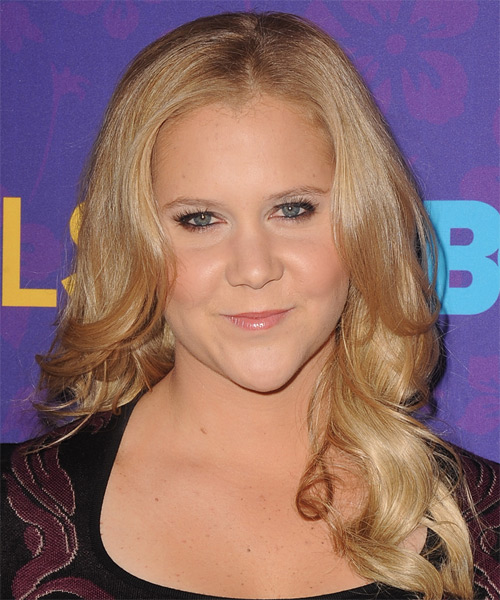

In [95]:
test_img_path = r"C:\Users\jjuus\OneDrive - purdue.edu\ECE 50024\Kaggle\test\test"
test_img = Image.open(join(test_img_path, '3415.jpg'))
display(test_img)

In [96]:
import torchvision

trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])
trans(test_img)

tensor([[[-0.2852, -0.4492, -0.3867,  ..., -0.1914, -0.1836, -0.0977],
         [-0.4023, -0.4414, -0.3867,  ..., -0.2539, -0.3398, -0.2227],
         [-0.3320, -0.3789, -0.3945,  ..., -0.2148, -0.3086, -0.1992],
         ...,
         [-0.7305, -0.8086, -0.8242,  ..., -0.4492, -0.5430, -0.6602],
         [-0.7695, -0.8320, -0.8398,  ..., -0.5039, -0.4648, -0.5117],
         [-0.6914, -0.7539, -0.7539,  ..., -0.2773, -0.4805, -0.5117]],

        [[-0.3320, -0.4961, -0.4570,  ..., -0.2773, -0.2695, -0.1836],
         [-0.4883, -0.5273, -0.4727,  ..., -0.3477, -0.4258, -0.3086],
         [-0.4492, -0.4961, -0.5117,  ..., -0.3086, -0.4023, -0.2930],
         ...,
         [-0.7461, -0.8242, -0.8398,  ..., -0.7461, -0.7461, -0.7461],
         [-0.7852, -0.8477, -0.8555,  ..., -0.8320, -0.7148, -0.6289],
         [-0.7070, -0.7695, -0.7695,  ..., -0.6211, -0.7617, -0.6367]],

        [[ 0.1523, -0.0117,  0.0508,  ...,  0.2617,  0.2617,  0.3477],
         [ 0.0273, -0.0117,  0.0430,  ...,  0

In [82]:
help(MTCNN)

Help on class MTCNN in module facenet_pytorch.models.mtcnn:

class MTCNN(torch.nn.modules.module.Module)
 |  MTCNN(image_size=160, margin=0, min_face_size=20, thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True, select_largest=True, selection_method=None, keep_all=False, device=None)
 |  
 |  MTCNN face detection module.
 |  
 |  This class loads pretrained P-, R-, and O-nets and returns images cropped to include the face
 |  only, given raw input images of one of the following types:
 |      - PIL image or list of PIL images
 |      - numpy.ndarray (uint8) representing either a single image (3D) or a batch of images (4D).
 |  Cropped faces can optionally be saved to file
 |  also.
 |  
 |  Keyword Arguments:
 |      image_size {int} -- Output image size in pixels. The image will be square. (default: {160})
 |      margin {int} -- Margin to add to bounding box, in terms of pixels in the final image. 
 |          Note that the application of the margin differs slightly from the 